# Castroville Slough Treatment Wetland Bioreactor: a preliminary Python-based analysis

#### Katherine Duncan

### *Background and study site introduction*

An estimated 21% of wetlands have been lost globally since 1700—with some regional hotspots in North America experiencing losses exceeding 50% (Fluet-Chouinard et al. 2023). The majority of this loss is due to agricultural and urban development (Ballut-Dajud et al. 2022; Fluet-Chouinard et al. 2023). Furthermore, agricultural runoff into waterways contributes to eutrophication that, in the worst-case-scenario, can lead to persistent anoxic or hypoxic zones (Howarth et al. 2011). Eutrophication often stems from nutrient runoff and the loss of wetlands further exacerbates the issue by contributing to increased eutrophication (Howarth et al. 2011, McCormick et al. 2009).

Water quality and wetlands in Monterey County have experienced declines similar to global trends. Historical maps and written records spanning the Elkhorn, Tembladero, and Moro Cojo Sloughs indicate significant loss of wetland habitat since the 1800s that includes tidal marshes, willow stands, and mudflats (Woolfolk 2020). However, the full extent of these losses has yet to be quantified, though local wetland habitats have predominantly been converted to agricultural or pastoral land (Woolfolk 2020). The Elkhorn Slough Reserve actively monitors water quality and eutrophication in local wetlands. In 2010, nearly all monitored sites, except one, exhibited moderate to hypereutrophic conditions (Hughes et al. 2010). However, by 2019 there was a notable improvement in water quality and eutrophication, particularly in areas associated with restoration efforts or those not subject to tidal restrictions (Hicks et al. 2019). Despite overall improvements in Elkhorn and Tembladero Sloughs, Moro Cojo Slough remained more heavily eutrophied (Hicks et al. 2019)—a discrepancy that may be attributed in part to Moro Cojo's hydrology being altered by agriculture-associated water-control structure such as pumps, drainage-channels, and levees (The Habitat Restoration Group 1996).

In [1]:
#Import cartopy and pyplot modules to create map for introduction plus later plots
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import matplotlib.pyplot as plt

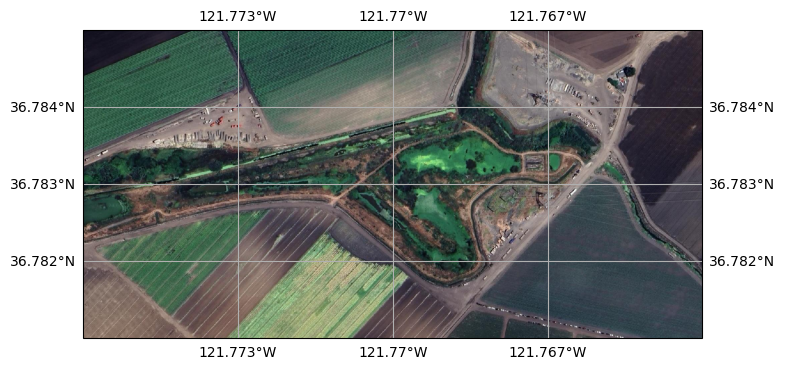

In [2]:
#Set latitudinal and longitudinal range of map
extent_wetland = [-121.775, -121.765, 36.781, 36.785]
# Request Google satellite image overlay
request = cimgt.GoogleTiles(style='satellite')
#Initialize figure and plot satellite imagery
plt.figure(figsize=[12,4])
ax = plt.axes(projection=ccrs.Mercator())
ax.set_extent(extent_wetland)
ax.add_image(request, 18)
#Format gridlines and reduce number of axis ticks/labels
gl = ax.gridlines(draw_labels=True)
gl.ylocator = plt.MaxNLocator(4)
gl.xlocator = plt.MaxNLocator(4)

<b>Figure 1.</b> Overhead map of CSTW and Castroville Ditch feeding in from the Southeast.

Conservation and pollution mitigation efforts offer a promising avenue for enhancing overall water quality in Moro Cojo. The Central Coast Wetlands Group, in collaboration with landowners, is actively engaged in such endeavors by focusing on restoring wetlands along the periphery of farmland in the form of treatment wetlands. These treatment wetlands serve three purposes: mitigating the influx of excess nutrients and pollutants into waterways, providing vital habitat for native species and migratory birds, and acting as a buffer against flooding. One easement managed by CCWG, the Castroville Slough Treatment Wetland (CSTW), has been operational since November 2016.

Agricultural runoff is pumped from the Castroville Ditch to CSTW where excess nutrients are removed from the water as it passes through CSTW and flows out into the remaining Castroville Wetland. Monitoring efforts indicate that while CSTW successfully mitigates excess nitrogen and phosphorus from agricultural runoff, the removal capacity has shifted as the wetland has matured. Within two months of November 2016, CSTW demonstrated significant reductions in excess nutrients passing through the easement with a 50% reduction in nitrate, 60% reduction in ammonia, and an 86% reduction in phosphate (Central Coast Wetlands Group 2016). A subsequent analysis in 2017 revealed shifts in nutrient removal rates, from when water entered to when it exited there was a  99.97% reduction in nitrate, a 96.95% reduction in ammonia, and an 81.43% reduction in phosphate (Conlen et al. 2017). While treatment wetlands are an effective method for mitigating nutrient runoff, other approaches to mitigation, such as bioreactors, can offer enhanced removal rates.

To test the effectiveness of four remediation strategies, CSTW hosted a 12-channel bioreactor experiment towards the beginning of the wetland located immediately after the forebay. Water passed from the forebay through the 12 treatment channels and water parameters in the forebay and from the 12-channles discharge was monitored and recorded by an autonomous analyzer that provided near-continuous resolution when functioning. An overarching goal of this experiment was to gauge different treatments' ability to enhance nutrient removal when paired with an agricultural wetland. This experiment ran from mid-2017 to early 2021; however, data from only one channel has been analyzed (Krone et al. 2022).

### *Bioreactor experiment setup, data description, and data wrangling*

<b>*Unpacking and parsing bioreactor channel data*<b/>

In [2]:
#Import packages and modules for data parsing, analysis, and visualization
import pandas as pd
import CSWTBioreactorFunctions as CBRF
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import seaborn as sns
import cmocean.cm as cmo

The BR_fileimport function in the CSWTBioreactorFunctions was created to read, parse, and store data from 12 CSV files containing Hydra data for the forebay and 12 treatments. All data was collected by and received from CCWG and their collaborators. 

In [3]:
#Importing and parsing forebay and channel data from csv files in HydraData directory
dffb,dfclist,dfc1,dfc2,dfc3,dfc4,dfc5,dfc6,dfc7,dfc8,dfc9,dfc10,dfc11,dfc12 = CBRF.fileimport()

The data sets have three different columns for nitrogen concentrations labeled 'nitrate', 's_nitrate', and 's_nitrogen'. The data for the first round of treatments primarily used the ‘nitrate’ column to record concentrations and has much fewer negative values than after treatments were transitioned and the ’s_nitrate’ and ’s_nitrogen’ columns were used to record data.

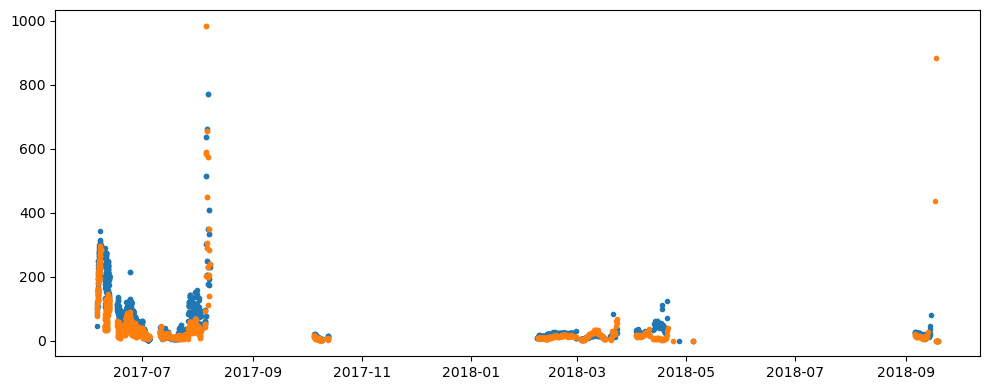

In [4]:
#
plt.figure(figsize = [10,4])
plt.plot(dffb['utc_time'], dffb['nitrate'], '.')
plt.plot(dfc9['utc_time'], dfc9['nitrate'], '.')
plt.tight_layout()

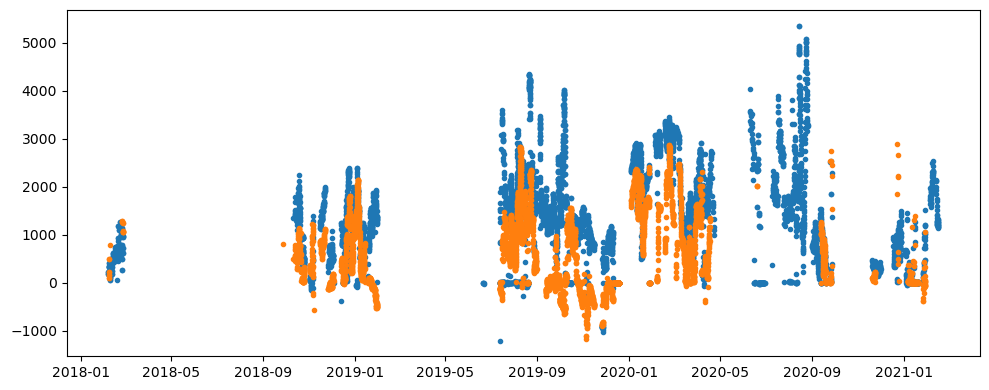

In [5]:
plt.figure(figsize = [10,4])
plt.plot(dffb['utc_time'], dffb['s_nitrate'],'.')
plt.plot(dfc1['utc_time'], dfc1['s_nitrate'], '.')
plt.tight_layout()

While the for the first round of treatments is comparatively lacking coverage, the cleaner nature of the data facilitates an easier  development of code for wrangling and analyzing data which can later be applied to data . Thus, I have decided to focus on a period spanning the June 2017 through July 2017 (06/05/2017 to 07/31/2017) which has semi-continuous nitrate data, but also offers a range of low and high concentrations. 

In [6]:
#Isolating forebay data to 06/05/2017 through 07/31/2017
dffb_nitrate = CBRF.timewindow(dffb,1496692995.71,1537302593.33)

#Naming dataframes based on treatment and channel while isolating them to 06/05/2017 through 07/31/2017
#Controls
dfc2_control = CBRF.timewindow(dfc2,1496692995.71,1537302593.33)
dfc7_control = CBRF.timewindow(dfc7,1496692995.71,1537302593.33)
dfc11_control = CBRF.timewindow(dfc11,1496692995.71,1537302593.33)
#Woodchip treatments
dfc1_woodchip = CBRF.timewindow(dfc1,1496692995.71,1537302593.33)
dfc5_woodchip = CBRF.timewindow(dfc5,1496692995.71,1537302593.33)
dfc9_woodchip = CBRF.timewindow(dfc9,1496692995.71,1537302593.33)
#Covered woodchip treatments
dfc3_covwoodchip = CBRF.timewindow(dfc3,1496692995.71,1537302593.33)
dfc8_covwoodchip = CBRF.timewindow(dfc8,1496692995.71,1537302593.33)
dfc12_covwoodchip = CBRF.timewindow(dfc12,1496692995.71,1537302593.33) 
#Hydrocotyle treatments
dfc4_hydrocotyle = CBRF.timewindow(dfc4,1496692995.71,1537302593.33)
dfc6_hydrocotyle = CBRF.timewindow(dfc6,1496692995.71,1537302593.33)
dfc10_hydrocotyle = CBRF.timewindow(dfc10,1496692995.71,1537302593.33)

The complete timeseries will be used for PCA analyses. The following code creates dataframes with rows with no values or negative values removed for PCA analysis.

In [18]:
#Forebay pre-PCA cleanup
dffb_PCA = CBRF.dfclean(dffb_nitrate)

#Control pre-PCA cleanup
dfc2_cPCA = CBRF.dfclean(dfc2_control)
dfc7_cPCA = CBRF.dfclean(dfc7_control)
dfc11_cPCA = CBRF.dfclean(dfc11_control)

#Woodchip treatment pre-PCA cleanup
dfc1_wPCA = CBRF.dfclean(dfc1_woodchip)
dfc5_wPCA = CBRF.dfclean(dfc5_woodchip)
dfc9_wPCA = CBRF.dfclean(dfc9_woodchip)

#Covered woodchip pre-PCA cleanup
dfc3_cwPCA = CBRF.dfclean(dfc3_covwoodchip)
dfc8_cwPCA = CBRF.dfclean(dfc8_covwoodchip)
dfc12_cwPCA = CBRF.dfclean(dfc12_covwoodchip)

#Hydrocotyle pre-PCA cleanup
dfc4_hPCA = CBRF.dfclean(dfc4_hydrocotyle)
dfc6_hPCA = CBRF.dfclean(dfc6_hydrocotyle)
dfc10_hPCA = CBRF.dfclean(dfc10_hydrocotyle)

I've selected a 3 day period to compare fluctuations in nitrate concentration and temperature across treatments. I found a period where 8 of 13 channels have near-continuous data coverage for nitrate and temperature for this purpose. The following code isolates a three day period running from 0:00 6/10/2017 to 12:00 6/12/17 UTC time then removes rows with negative or no values for nitrate and temperature data.

In [8]:
#Creating discreate timeframes for plotted values from the whole timeseries
dffb_timesub = CBRF.timewindow(dffb_nitrate,1497051241,1497282115)
dfc1_timesub = CBRF.timewindow(dfc1_woodchip,1497051241,1497282115)
dfc2_timesub = CBRF.timewindow(dfc2_control,1497051241,1497282115)
dfc3_timesub = CBRF.timewindow(dfc3_covwoodchip,1497051241,1497282115)
dfc4_timesub = CBRF.timewindow(dfc4_hydrocotyle,1497051241,1497282115)
dfc5_timesub = CBRF.timewindow(dfc5_woodchip,1497051241,1497282115)
dfc6_timesub = CBRF.timewindow(dfc6_hydrocotyle,1497051241,1497282115)
dfc7_timesub = CBRF.timewindow(dfc7_control,1497051241,1497282115)
dfc8_timesub = CBRF.timewindow(dfc8_covwoodchip,1497051241,1497282115)
dfc9_timesub = CBRF.timewindow(dfc9_woodchip,1497051241,1497282115)
dfc10_timesub = CBRF.timewindow(dfc10_hydrocotyle,1497051241,1497282115)
dfc11_timesub = CBRF.timewindow(dfc11_control,1497051241,1497282115)
dfc12_timesub = CBRF.timewindow(dfc12_covwoodchip,1497051241,1497282115)
#Creating dataframes with rows with no values or negative values removed from temperature and nitrate columns for plotted timeseries 
#forebay data
dffb_plot = CBRF.dfclean_nitratetemp(dffb_timesub)
#Controls
dfc2_cPlot = CBRF.dfclean_nitratetemp(dfc2_timesub)
dfc7_cPlot = CBRF.dfclean_nitratetemp(dfc7_timesub)
dfc11_cPlot = CBRF.dfclean_nitratetemp(dfc11_timesub)
#Woodchip treatments
dfc1_wPlot = CBRF.dfclean_nitratetemp(dfc1_timesub)
dfc5_wPlot = CBRF.dfclean_nitratetemp(dfc5_timesub)
dfc9_wPlot = CBRF.dfclean_nitratetemp(dfc9_timesub)
#Covered woodchip treatments
dfc3_cwPlot = CBRF.dfclean_nitratetemp(dfc3_timesub)
dfc8_cwPlot = CBRF.dfclean_nitratetemp(dfc8_timesub)
dfc12_cwPlot = CBRF.dfclean_nitratetemp(dfc12_timesub)
#Hydrocotyle treatments
dfc4_hPlot = CBRF.dfclean_nitratetemp(dfc4_timesub)
dfc6_hPlot = CBRF.dfclean_nitratetemp(dfc6_timesub)
dfc10_hPlot = CBRF.dfclean_nitratetemp(dfc10_timesub)

### *Principle component analysis*

In [27]:
varlist=['temp','sal','nitrate','hdo','ph'] #Initialize variable list for PCA analysis

#Utilize BioreactorPCA function to generate eigenvectors, eigenvalues, PC factor loadings, and other variables for the forebay and all channels
fbPCA_zscores, fbPCA_evalues, fbPCA_evectors, fbPCA_PC1pvar, fbPCA_PC2pvar, fbPCA_FactorMatrix, fbPCA_PCscores, fbPCA_TimeMatrix = CBRF.BioreactorPCA(dffb_PCA, varlist) #Forebay
#Control channel PCA calculations
c2PCA_zscores, c2PCA_evalues, c2PCA_evectors, c2PCA_PC1pvar, c2PCA_PC2pvar, c2PCA_FactorMatrix, c2PCA_PCscores, c2PCA_TimeMatrix = CBRF.BioreactorPCA(dfc2_cPCA, varlist)
c7PCA_zscores, c7PCA_evalues, c7PCA_evectors, c7PCA_PC1pvar, c7PCA_PC2pvar, c7PCA_FactorMatrix, c7PCA_PCscores, c7PCA_TimeMatrix = CBRF.BioreactorPCA(dfc7_cPCA, varlist)
c11PCA_zscores, c11PCA_evalues, c11PCA_evectors, c11PCA_PC1pvar, c11PCA_PC2pvar, c11PCA_FactorMatrix, c11PCA_PCscores, c11PCA_TimeMatrix = CBRF.BioreactorPCA(dfc11_cPCA, varlist)
#Woodchip channel PCA calculations
c1PCA_zscores, c1PCA_evalues, c1PCA_evectors, c1PCA_PC1pvar, c1PCA_PC2pvar, c1PCA_FactorMatrix, c1PCA_PCscores, c1PCA_TimeMatrix = CBRF.BioreactorPCA(dfc1_wPCA, varlist)
c5PCA_zscores, c5PCA_evalues, c5PCA_evectors, c5PCA_PC1pvar, c5PCA_PC2pvar, c5PCA_FactorMatrix, c5PCA_PCscores, c5PCA_TimeMatrix = CBRF.BioreactorPCA(dfc5_wPCA, varlist)
c9PCA_zscores, c9PCA_evalues, c9PCA_evectors, c9PCA_PC1pvar, c9PCA_PC2pvar, c9PCA_FactorMatrix, c9PCA_PCscores, c9PCA_TimeMatrix = CBRF.BioreactorPCA(dfc9_wPCA, varlist)

#Covered woodchip channel PCA calculations
c3PCA_zscores, c3PCA_evalues, c3PCA_evectors, c3PCA_PC1pvar, c3PCA_PC2pvar, c3PCA_FactorMatrix, c3PCA_PCscores, c3PCA_TimeMatrix = CBRF.BioreactorPCA(dfc3_cwPCA, varlist)
c8PCA_zscores, c8PCA_evalues, c8PCA_evectors, c8PCA_PC1pvar, c8PCA_PC2pvar, c8PCA_FactorMatrix, c8PCA_PCscores, c8PCA_TimeMatrix = CBRF.BioreactorPCA(dfc8_cwPCA, varlist)
c12PCA_zscores, c12PCA_evalues, c12PCA_evectors, c12PCA_PC1pvar, c12PCA_PC2pvar, c12PCA_FactorMatrix, c12PCA_PCscores, c12PCA_TimeMatrix = CBRF.BioreactorPCA(dfc12_cwPCA, varlist)

#Hydrocotyle channel PCA calculations
c4PCA_zscores, c4PCA_evalues, c4PCA_evectors, c4PCA_PC1pvar, c4PCA_PC2pvar, c4PCA_FactorMatrix, c4PCA_PCscores, c4PCA_TimeMatrix = CBRF.BioreactorPCA(dfc4_hPCA, varlist)
c6PCA_zscores, c6PCA_evalues, c6PCA_evectors, c6PCA_PC1pvar, c6PCA_PC2pvar, c6PCA_FactorMatrix, c6PCA_PCscores, c6PCA_TimeMatrix = CBRF.BioreactorPCA(dfc6_hPCA, varlist)
c10PCA_zscores, c10PCA_evalues, c10PCA_evectors, c10PCA_PC1pvar, c10PCA_PC2pvar, c10PCA_FactorMatrix, c10PCA_PCscores, c10PCA_TimeMatrix = CBRF.BioreactorPCA(dfc10_hPCA, varlist)

#### *Forebay and control treatments*

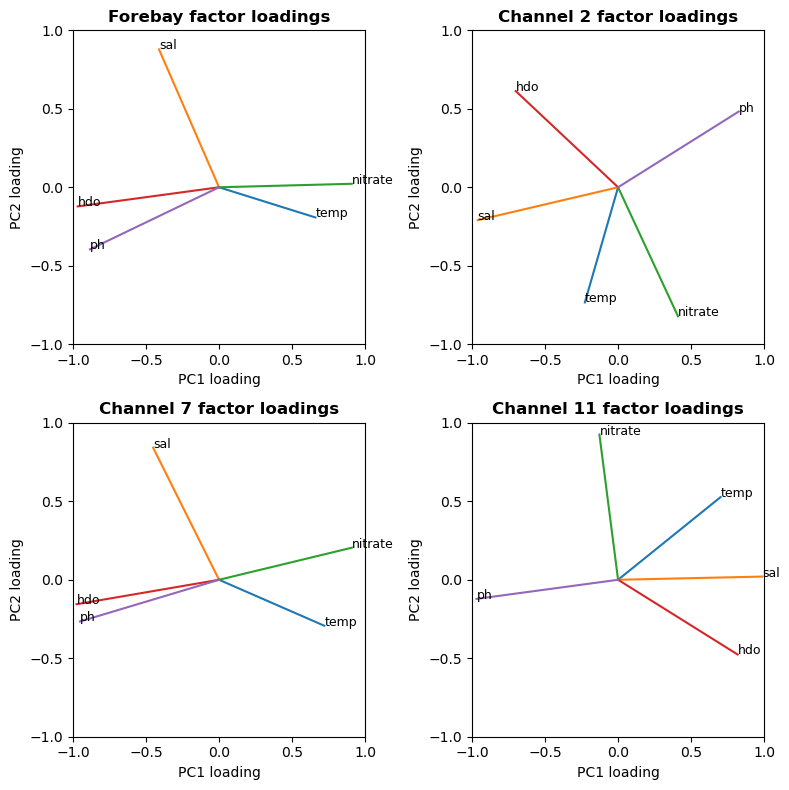

In [28]:
#Initialize figure with 4 subplots
figs, axs = plt.subplots(nrows=2, ncols=2, figsize=[8, 8])
    
#Setup forebay factor loading subplot
axs[0, 0].set_xlim([-1, 1])
axs[0, 0].set_ylim([-1, 1])
axs[0, 0].set_xlabel('PC1 loading', fontsize=10)
axs[0, 0].set_ylabel('PC2 loading', fontsize=10)
axs[0, 0].set_title('Forebay factor loadings', fontweight='bold')
axs[0, 0].set_xticks([-1, -0.5, 0, 0.5, 1])
axs[0, 0].set_yticks([-1, -0.5, 0, 0.5, 1])
# Plot factor loadings the forebay
for i, txt in enumerate(varlist):
    axs[0, 0].plot([0, fbPCA_FactorMatrix[i, 0]], [0, fbPCA_FactorMatrix[i, 1]], '-')
    axs[0, 0].text(fbPCA_FactorMatrix[i, 0], fbPCA_FactorMatrix[i, 1], txt, fontsize=9)

#Setup forebay factor loading subplot for channel 2
axs[0, 1].set_xlim([-1, 1])
axs[0, 1].set_ylim([-1, 1])
axs[0, 1].set_xlabel('PC1 loading', fontsize=10)
axs[0, 1].set_ylabel('PC2 loading', fontsize=10)
axs[0, 1].set_title('Channel 2 factor loadings', fontweight='bold')
axs[0, 1].set_xticks([-1, -0.5, 0, 0.5, 1])
axs[0, 1].set_yticks([-1, -0.5, 0, 0.5, 1])
#Plot factor loadings the channel 2
for i, txt in enumerate(varlist):
    axs[0, 1].plot([0, c2PCA_FactorMatrix[i, 0]], [0, c2PCA_FactorMatrix[i, 1]], '-')
    axs[0, 1].text(c2PCA_FactorMatrix[i, 0], c2PCA_FactorMatrix[i, 1], txt, fontsize=9)

#Setup forebay factor loading subplot for channel 7
axs[1, 0].set_xlim([-1, 1])
axs[1, 0].set_ylim([-1, 1])
axs[1, 0].set_xlabel('PC1 loading', fontsize=10)
axs[1, 0].set_ylabel('PC2 loading', fontsize=10)
axs[1, 0].set_title('Channel 7 factor loadings', fontweight='bold')
axs[1, 0].set_xticks([-1, -0.5, 0, 0.5, 1])
axs[1, 0].set_yticks([-1, -0.5, 0, 0.5, 1])
#Plot factor loadings the channel 7
for i, txt in enumerate(varlist):
    axs[1, 0].plot([0, c7PCA_FactorMatrix[i, 0]], [0, c7PCA_FactorMatrix[i, 1]], '-')
    axs[1, 0].text(c7PCA_FactorMatrix[i, 0], c7PCA_FactorMatrix[i, 1], txt,fontsize=9)

#Setup forebay factor loading subplot for channel 11
axs[1, 1].set_xlim([-1, 1])
axs[1, 1].set_ylim([-1, 1])
axs[1, 1].set_xlabel('PC1 loading', fontsize=10)
axs[1, 1].set_ylabel('PC2 loading', fontsize=10)
axs[1, 1].set_title('Channel 11 factor loadings', fontweight='bold')
axs[1, 1].set_xticks([-1, -0.5, 0, 0.5, 1])
axs[1, 1].set_yticks([-1, -0.5, 0, 0.5, 1])
#Plot factor loadings the channel 11
for i, txt in enumerate(varlist):
    axs[1, 1].plot([0, c11PCA_FactorMatrix[i, 0]], [0, c11PCA_FactorMatrix[i, 1]], '-')
    axs[1, 1].text(c11PCA_FactorMatrix[i, 0], c11PCA_FactorMatrix[i, 1], txt, fontsize=9)

plt.tight_layout() #Cleanup subplots

#### *Forebay and woodchip treatments*

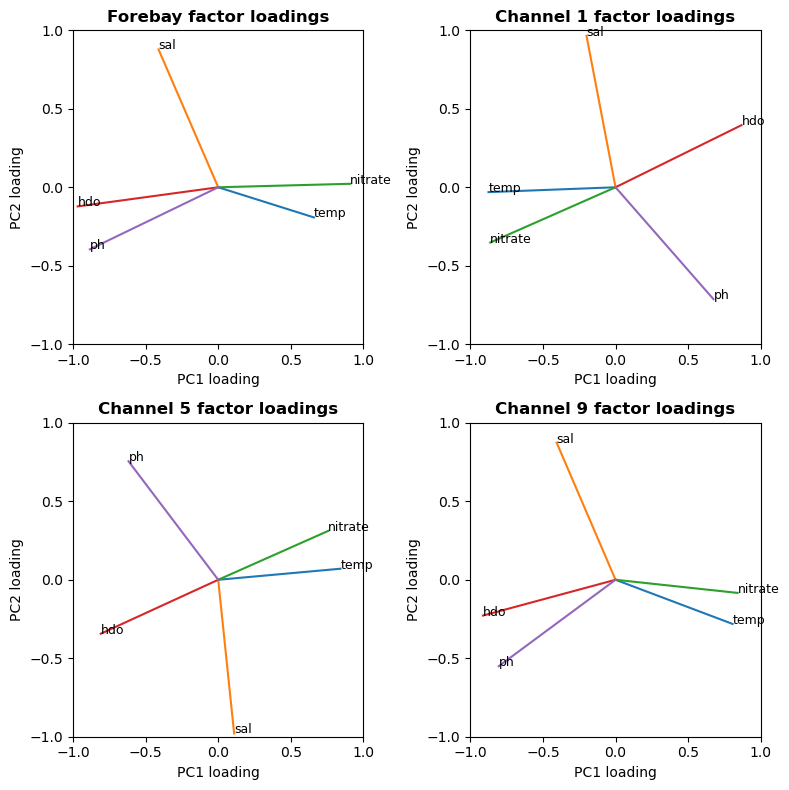

In [29]:
#Initialize figure with 4 subplots
figs, axs = plt.subplots(nrows=2, ncols=2, figsize=[8, 8])
    
#Setup forebay factor loading subplot
axs[0, 0].set_xlim([-1, 1])
axs[0, 0].set_ylim([-1, 1])
axs[0, 0].set_xlabel('PC1 loading', fontsize=10)
axs[0, 0].set_ylabel('PC2 loading', fontsize=10)
axs[0, 0].set_title('Forebay factor loadings', fontweight='bold')
axs[0, 0].set_xticks([-1, -0.5, 0, 0.5, 1])
axs[0, 0].set_yticks([-1, -0.5, 0, 0.5, 1])
# Plot factor loadings the forebay
for i, txt in enumerate(varlist):
    axs[0, 0].plot([0, fbPCA_FactorMatrix[i, 0]], [0, fbPCA_FactorMatrix[i, 1]], '-')
    axs[0, 0].text(fbPCA_FactorMatrix[i, 0], fbPCA_FactorMatrix[i, 1], txt, fontsize=9)

#Setup forebay factor loading subplot for channel 1
axs[0, 1].set_xlim([-1, 1])
axs[0, 1].set_ylim([-1, 1])
axs[0, 1].set_xlabel('PC1 loading', fontsize=10)
axs[0, 1].set_ylabel('PC2 loading', fontsize=10)
axs[0, 1].set_title('Channel 1 factor loadings', fontweight='bold')
axs[0, 1].set_xticks([-1, -0.5, 0, 0.5, 1])
axs[0, 1].set_yticks([-1, -0.5, 0, 0.5, 1])
#Plot factor loadings the channel 1
for i, txt in enumerate(varlist):
    axs[0, 1].plot([0, c1PCA_FactorMatrix[i, 0]], [0, c1PCA_FactorMatrix[i, 1]], '-')
    axs[0, 1].text(c1PCA_FactorMatrix[i, 0], c1PCA_FactorMatrix[i, 1], txt, fontsize=9)

#Setup forebay factor loading subplot for channel 5
axs[1, 0].set_xlim([-1, 1])
axs[1, 0].set_ylim([-1, 1])
axs[1, 0].set_xlabel('PC1 loading', fontsize=10)
axs[1, 0].set_ylabel('PC2 loading', fontsize=10)
axs[1, 0].set_title('Channel 5 factor loadings', fontweight='bold')
axs[1, 0].set_xticks([-1, -0.5, 0, 0.5, 1])
axs[1, 0].set_yticks([-1, -0.5, 0, 0.5, 1])
#Plot factor loadings the channel 5
for i, txt in enumerate(varlist):
    axs[1, 0].plot([0, c5PCA_FactorMatrix[i, 0]], [0, c5PCA_FactorMatrix[i, 1]], '-')
    axs[1, 0].text(c5PCA_FactorMatrix[i, 0], c5PCA_FactorMatrix[i, 1], txt,fontsize=9)

#Setup forebay factor loading subplot for channel 9
axs[1, 1].set_xlim([-1, 1])
axs[1, 1].set_ylim([-1, 1])
axs[1, 1].set_xlabel('PC1 loading', fontsize=10)
axs[1, 1].set_ylabel('PC2 loading', fontsize=10)
axs[1, 1].set_title('Channel 9 factor loadings', fontweight='bold')
axs[1, 1].set_xticks([-1, -0.5, 0, 0.5, 1])
axs[1, 1].set_yticks([-1, -0.5, 0, 0.5, 1])
#Plot factor loadings the channel 9
for i, txt in enumerate(varlist):
    axs[1, 1].plot([0, c9PCA_FactorMatrix[i, 0]], [0, c9PCA_FactorMatrix[i, 1]], '-')
    axs[1, 1].text(c9PCA_FactorMatrix[i, 0], c9PCA_FactorMatrix[i, 1], txt, fontsize=9)

plt.tight_layout() #Cleanup subplots

#### *Forebay and covered woodchip treatments*

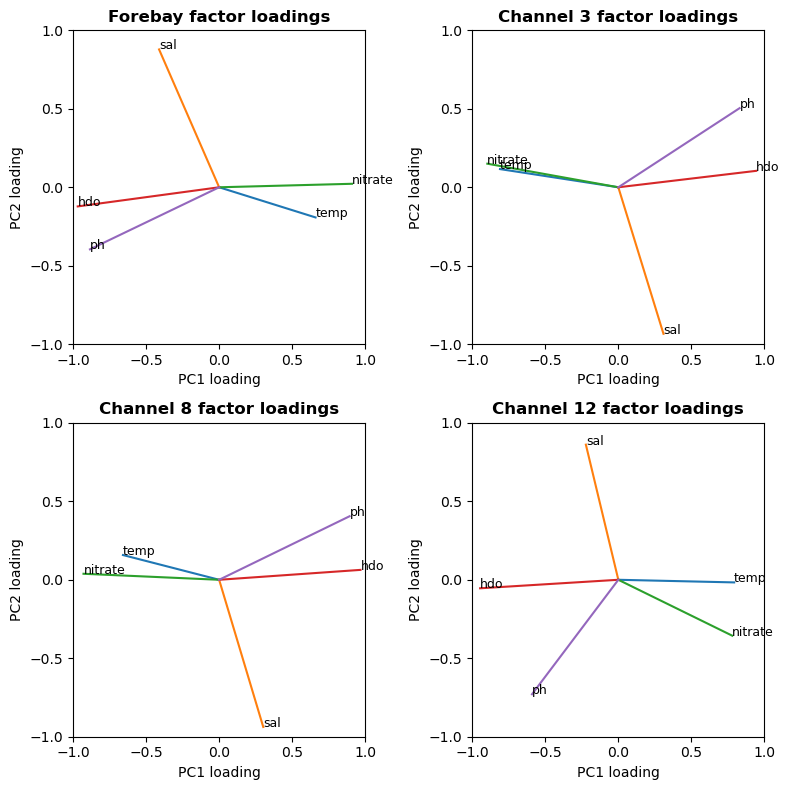

In [30]:
#Initialize figure with 4 subplots
figs, axs = plt.subplots(nrows=2, ncols=2, figsize=[8, 8])
    
#Setup forebay factor loading subplot
axs[0, 0].set_xlim([-1, 1])
axs[0, 0].set_ylim([-1, 1])
axs[0, 0].set_xlabel('PC1 loading', fontsize=10)
axs[0, 0].set_ylabel('PC2 loading', fontsize=10)
axs[0, 0].set_title('Forebay factor loadings', fontweight='bold')
axs[0, 0].set_xticks([-1, -0.5, 0, 0.5, 1])
axs[0, 0].set_yticks([-1, -0.5, 0, 0.5, 1])
# Plot factor loadings the forebay
for i, txt in enumerate(varlist):
    axs[0, 0].plot([0, fbPCA_FactorMatrix[i, 0]], [0, fbPCA_FactorMatrix[i, 1]], '-')
    axs[0, 0].text(fbPCA_FactorMatrix[i, 0], fbPCA_FactorMatrix[i, 1], txt, fontsize=9)

#Setup forebay factor loading subplot for channel 3
axs[0, 1].set_xlim([-1, 1])
axs[0, 1].set_ylim([-1, 1])
axs[0, 1].set_xlabel('PC1 loading', fontsize=10)
axs[0, 1].set_ylabel('PC2 loading', fontsize=10)
axs[0, 1].set_title('Channel 3 factor loadings', fontweight='bold')
axs[0, 1].set_xticks([-1, -0.5, 0, 0.5, 1])
axs[0, 1].set_yticks([-1, -0.5, 0, 0.5, 1])
#Plot factor loadings the channel 3
for i, txt in enumerate(varlist):
    axs[0, 1].plot([0, c3PCA_FactorMatrix[i, 0]], [0, c3PCA_FactorMatrix[i, 1]], '-')
    axs[0, 1].text(c3PCA_FactorMatrix[i, 0], c3PCA_FactorMatrix[i, 1], txt, fontsize=9)

#Setup forebay factor loading subplot for channel 8
axs[1, 0].set_xlim([-1, 1])
axs[1, 0].set_ylim([-1, 1])
axs[1, 0].set_xlabel('PC1 loading', fontsize=10)
axs[1, 0].set_ylabel('PC2 loading', fontsize=10)
axs[1, 0].set_title('Channel 8 factor loadings', fontweight='bold')
axs[1, 0].set_xticks([-1, -0.5, 0, 0.5, 1])
axs[1, 0].set_yticks([-1, -0.5, 0, 0.5, 1])
#Plot factor loadings the channel 8
for i, txt in enumerate(varlist):
    axs[1, 0].plot([0, c8PCA_FactorMatrix[i, 0]], [0, c8PCA_FactorMatrix[i, 1]], '-')
    axs[1, 0].text(c8PCA_FactorMatrix[i, 0], c8PCA_FactorMatrix[i, 1], txt,fontsize=9)

#Setup forebay factor loading subplot for channel 12
axs[1, 1].set_xlim([-1, 1])
axs[1, 1].set_ylim([-1, 1])
axs[1, 1].set_xlabel('PC1 loading', fontsize=10)
axs[1, 1].set_ylabel('PC2 loading', fontsize=10)
axs[1, 1].set_title('Channel 12 factor loadings', fontweight='bold')
axs[1, 1].set_xticks([-1, -0.5, 0, 0.5, 1])
axs[1, 1].set_yticks([-1, -0.5, 0, 0.5, 1])
#Plot factor loadings the channel 12
for i, txt in enumerate(varlist):
    axs[1, 1].plot([0, c12PCA_FactorMatrix[i, 0]], [0, c12PCA_FactorMatrix[i, 1]], '-')
    axs[1, 1].text(c12PCA_FactorMatrix[i, 0], c12PCA_FactorMatrix[i, 1], txt, fontsize=9)

plt.tight_layout() #Cleanup subplots

#### *Forebay and Hydrocotyle treatments*

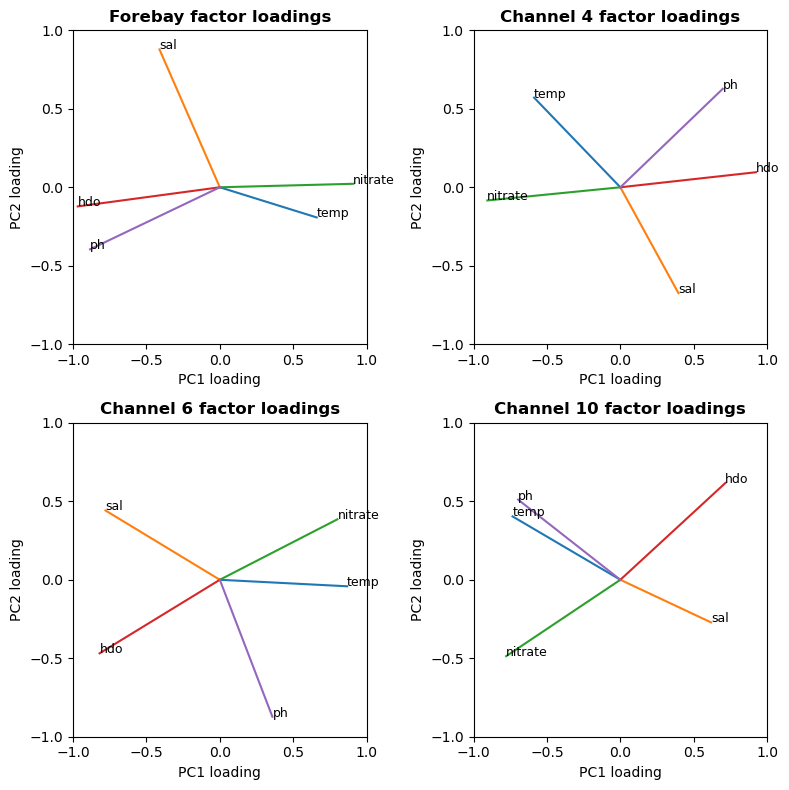

In [31]:
#Initialize figure with 4 subplots
figs, axs = plt.subplots(nrows=2, ncols=2, figsize=[8, 8])
    
#Setup forebay factor loading subplot
axs[0, 0].set_xlim([-1, 1])
axs[0, 0].set_ylim([-1, 1])
axs[0, 0].set_xlabel('PC1 loading', fontsize=10)
axs[0, 0].set_ylabel('PC2 loading', fontsize=10)
axs[0, 0].set_title('Forebay factor loadings', fontweight='bold')
axs[0, 0].set_xticks([-1, -0.5, 0, 0.5, 1])
axs[0, 0].set_yticks([-1, -0.5, 0, 0.5, 1])
# Plot factor loadings the forebay
for i, txt in enumerate(varlist):
    axs[0, 0].plot([0, fbPCA_FactorMatrix[i, 0]], [0, fbPCA_FactorMatrix[i, 1]], '-')
    axs[0, 0].text(fbPCA_FactorMatrix[i, 0], fbPCA_FactorMatrix[i, 1], txt, fontsize=9)

#Setup forebay factor loading subplot for channel 4
axs[0, 1].set_xlim([-1, 1])
axs[0, 1].set_ylim([-1, 1])
axs[0, 1].set_xlabel('PC1 loading', fontsize=10)
axs[0, 1].set_ylabel('PC2 loading', fontsize=10)
axs[0, 1].set_title('Channel 4 factor loadings', fontweight='bold')
axs[0, 1].set_xticks([-1, -0.5, 0, 0.5, 1])
axs[0, 1].set_yticks([-1, -0.5, 0, 0.5, 1])
#Plot factor loadings the channel 4
for i, txt in enumerate(varlist):
    axs[0, 1].plot([0, c4PCA_FactorMatrix[i, 0]], [0, c4PCA_FactorMatrix[i, 1]], '-')
    axs[0, 1].text(c4PCA_FactorMatrix[i, 0], c4PCA_FactorMatrix[i, 1], txt, fontsize=9)

#Setup forebay factor loading subplot for channel 6
axs[1, 0].set_xlim([-1, 1])
axs[1, 0].set_ylim([-1, 1])
axs[1, 0].set_xlabel('PC1 loading', fontsize=10)
axs[1, 0].set_ylabel('PC2 loading', fontsize=10)
axs[1, 0].set_title('Channel 6 factor loadings', fontweight='bold')
axs[1, 0].set_xticks([-1, -0.5, 0, 0.5, 1])
axs[1, 0].set_yticks([-1, -0.5, 0, 0.5, 1])
#Plot factor loadings the channel 6
for i, txt in enumerate(varlist):
    axs[1, 0].plot([0, c6PCA_FactorMatrix[i, 0]], [0, c6PCA_FactorMatrix[i, 1]], '-')
    axs[1, 0].text(c6PCA_FactorMatrix[i, 0], c6PCA_FactorMatrix[i, 1], txt,fontsize=9)

#Setup forebay factor loading subplot for channel 10
axs[1, 1].set_xlim([-1, 1])
axs[1, 1].set_ylim([-1, 1])
axs[1, 1].set_xlabel('PC1 loading', fontsize=10)
axs[1, 1].set_ylabel('PC2 loading', fontsize=10)
axs[1, 1].set_title('Channel 10 factor loadings', fontweight='bold')
axs[1, 1].set_xticks([-1, -0.5, 0, 0.5, 1])
axs[1, 1].set_yticks([-1, -0.5, 0, 0.5, 1])
#Plot factor loadings the channel 10
for i, txt in enumerate(varlist):
    axs[1, 1].plot([0, c10PCA_FactorMatrix[i, 0]], [0, c10PCA_FactorMatrix[i, 1]], '-')
    axs[1, 1].text(c10PCA_FactorMatrix[i, 0], c10PCA_FactorMatrix[i, 1], txt, fontsize=9)

plt.tight_layout() #Cleanup subplots

### *Nitrate and temperature timeseries*

/var/folders/_w/1g9wcjz974q54mr5m7n8phmr0000gn/T/ipykernel_27975/3571535935.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['00:00 6/10/17', '12:00 6/10/17', '00:00 6/11/17' , '12:00 6/11/17', '00:00 6/12/17', '12:00 6/12/17'])


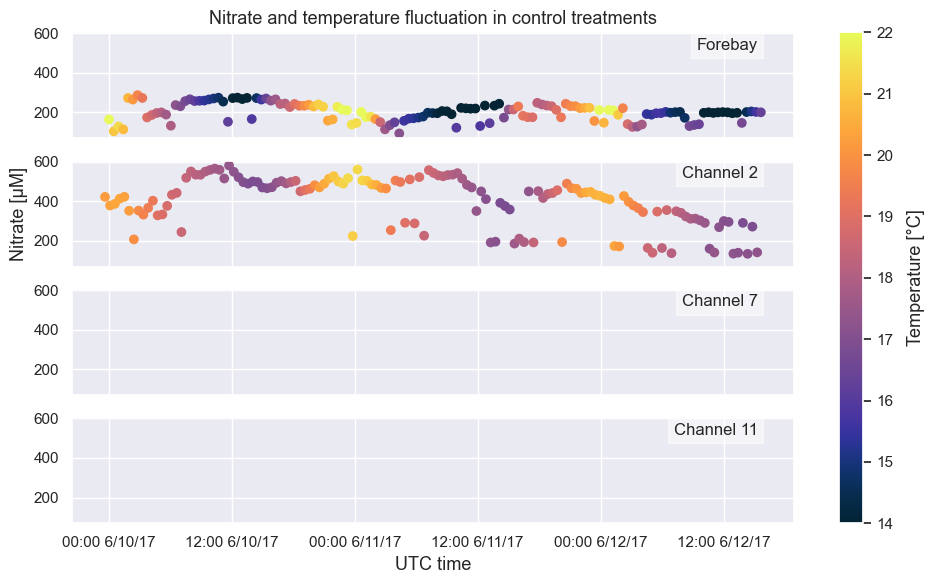

In [14]:
#Control channel temp plots
sns.set()
fig, axs = plt.subplots(4, sharex=True, sharey=True, figsize=[10,6])
scatter0 = axs[0].scatter(dffb_plot['utc_time'], dffb_plot['nitrate'], c=dffb_plot['temp'], cmap=cmo.thermal, vmin=14.0, vmax=22.0)
axs[0].set_title('Nitrate and temperature fluctuation in control treatments', fontsize=13)

scatter1 = axs[1].scatter(dfc2_cPlot['utc_time'], dfc2_cPlot['nitrate'], c=dfc2_cPlot['temp'], cmap=cmo.thermal,vmin=14.0, vmax=22.0)
axs[1].set_ylabel('Nitrate [μM]', fontsize=13)

scatter2 = axs[2].scatter(dfc7_cPlot['utc_time'], dfc7_cPlot['nitrate'], c=dfc7_cPlot['temp'], cmap=cmo.thermal,vmin=14.0, vmax=22.0)

scatter3 = axs[3].scatter(dfc11_cPlot['utc_time'], dfc11_cPlot['nitrate'], c=dfc11_cPlot['temp'], cmap=cmo.thermal,vmin=14.0, vmax=22.0)
axs[3].set_xlabel('UTC time', fontsize=13)

axs[0].text(0.95, 0.95, 'Forebay', transform=axs[0].transAxes, fontsize=12, va='top', ha='right', bbox=dict(facecolor='white', alpha=0.5))
plt.tight_layout()
axs[1].text(0.95, 0.95, 'Channel 2', transform=axs[1].transAxes, fontsize=12, va='top', ha='right', bbox=dict(facecolor='white', alpha=0.5))
plt.tight_layout()
axs[2].text(0.95, 0.95, 'Channel 7', transform=axs[2].transAxes, fontsize=12, va='top', ha='right', bbox=dict(facecolor='white', alpha=0.5))
plt.tight_layout()
axs[3].text(0.95, 0.95, 'Channel 11', transform=axs[3].transAxes, fontsize=12, va='top', ha='right', bbox=dict(facecolor='white', alpha=0.5))
plt.tight_layout()

plt.gca().set_xticklabels(['00:00 6/10/17', '12:00 6/10/17', '00:00 6/11/17' , '12:00 6/11/17', '00:00 6/12/17', '12:00 6/12/17'])

cbar = fig.colorbar(scatter2, ax=axs.ravel().tolist(), orientation='vertical', pad=0.05)  # Adjust pad value for more spacing
cbar.set_label('Temperature [°C]', fontsize=13, labelpad=10)

/var/folders/_w/1g9wcjz974q54mr5m7n8phmr0000gn/T/ipykernel_27975/2905891401.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['00:00 6/10/17', '12:00 6/10/17', '00:00 6/11/17' , '12:00 6/11/17', '00:00 6/12/17', '12:00 6/12/17'])


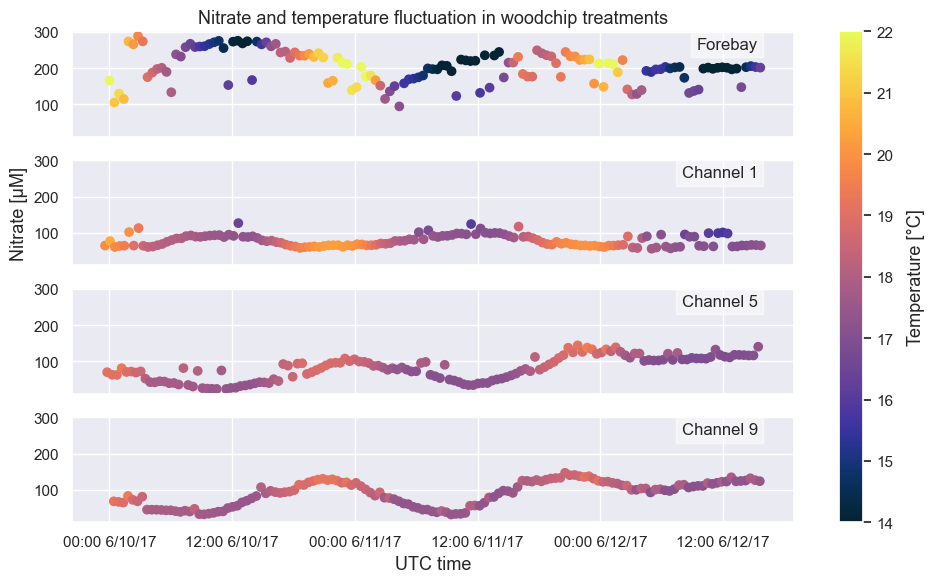

In [13]:
#Woodchip channel temp plots
sns.set()
fig, axs = plt.subplots(4, sharex=True, sharey=True, figsize=[10,6])
scatter0 = axs[0].scatter(dffb_plot['utc_time'], dffb_plot['nitrate'], c=dffb_plot['temp'], cmap=cmo.thermal, vmin=14.0, vmax=22.0)
axs[0].set_title('Nitrate and temperature fluctuation in woodchip treatments', fontsize=13)

scatter1 = axs[1].scatter(dfc1_wPlot['utc_time'], dfc1_wPlot['nitrate'], c=dfc1_wPlot['temp'], cmap=cmo.thermal,vmin=14.0, vmax=22.0)
axs[1].set_ylabel('Nitrate [μM]', fontsize=13)

scatter2 = axs[2].scatter(dfc5_wPlot['utc_time'], dfc5_wPlot['nitrate'], c=dfc5_wPlot['temp'], cmap=cmo.thermal,vmin=14.0, vmax=22.0)

scatter3 = axs[3].scatter(dfc9_wPlot['utc_time'], dfc9_wPlot['nitrate'], c=dfc9_wPlot['temp'], cmap=cmo.thermal,vmin=14.0, vmax=22.0)
axs[3].set_xlabel('UTC time', fontsize=13)

axs[0].text(0.95, 0.95, 'Forebay', transform=axs[0].transAxes, fontsize=12, va='top', ha='right', bbox=dict(facecolor='white', alpha=0.5))
plt.tight_layout()
axs[1].text(0.95, 0.95, 'Channel 1', transform=axs[1].transAxes, fontsize=12, va='top', ha='right', bbox=dict(facecolor='white', alpha=0.5))
plt.tight_layout()
axs[2].text(0.95, 0.95, 'Channel 5', transform=axs[2].transAxes, fontsize=12, va='top', ha='right', bbox=dict(facecolor='white', alpha=0.5))
plt.tight_layout()
axs[3].text(0.95, 0.95, 'Channel 9', transform=axs[3].transAxes, fontsize=12, va='top', ha='right', bbox=dict(facecolor='white', alpha=0.5))
plt.tight_layout()

plt.gca().set_xticklabels(['00:00 6/10/17', '12:00 6/10/17', '00:00 6/11/17' , '12:00 6/11/17', '00:00 6/12/17', '12:00 6/12/17'])

cbar = fig.colorbar(scatter2, ax=axs.ravel().tolist(), orientation='vertical', pad=0.05)  # Adjust pad value for more spacing
cbar.set_label('Temperature [°C]', fontsize=13, labelpad=10)

/var/folders/_w/1g9wcjz974q54mr5m7n8phmr0000gn/T/ipykernel_27975/2441647296.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['00:00 6/10/17', '12:00 6/10/17', '00:00 6/11/17' , '12:00 6/11/17', '00:00 6/12/17', '12:00 6/12/17'])


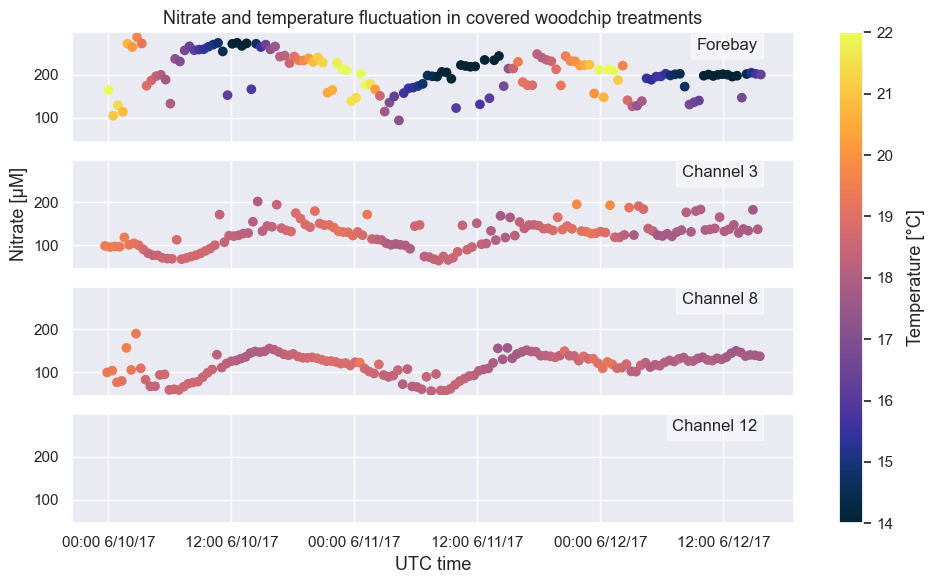

In [15]:
#Covered woodchip channel temp plots
sns.set()
fig, axs = plt.subplots(4, sharex=True, sharey=True, figsize=[10,6])
scatter0 = axs[0].scatter(dffb_plot['utc_time'], dffb_plot['nitrate'], c=dffb_plot['temp'], cmap=cmo.thermal, vmin=14.0, vmax=22.0)
axs[0].set_title('Nitrate and temperature fluctuation in covered woodchip treatments', fontsize=13)

scatter1 = axs[1].scatter(dfc3_cwPlot['utc_time'], dfc3_cwPlot['nitrate'], c=dfc3_cwPlot['temp'], cmap=cmo.thermal,vmin=14.0, vmax=22.0)
axs[1].set_ylabel('Nitrate [μM]', fontsize=13)

scatter2 = axs[2].scatter(dfc8_cwPlot['utc_time'], dfc8_cwPlot['nitrate'], c=dfc8_cwPlot['temp'], cmap=cmo.thermal,vmin=14.0, vmax=22.0)

scatter3 = axs[3].scatter(dfc12_cwPlot['utc_time'], dfc12_cwPlot['nitrate'], c=dfc12_cwPlot['temp'], cmap=cmo.thermal,vmin=14.0, vmax=22.0)
axs[3].set_xlabel('UTC time', fontsize=13)

axs[0].text(0.95, 0.95, 'Forebay', transform=axs[0].transAxes, fontsize=12, va='top', ha='right', bbox=dict(facecolor='white', alpha=0.5))
plt.tight_layout()
axs[1].text(0.95, 0.95, 'Channel 3', transform=axs[1].transAxes, fontsize=12, va='top', ha='right', bbox=dict(facecolor='white', alpha=0.5))
plt.tight_layout()
axs[2].text(0.95, 0.95, 'Channel 8', transform=axs[2].transAxes, fontsize=12, va='top', ha='right', bbox=dict(facecolor='white', alpha=0.5))
plt.tight_layout()
axs[3].text(0.95, 0.95, 'Channel 12', transform=axs[3].transAxes, fontsize=12, va='top', ha='right', bbox=dict(facecolor='white', alpha=0.5))
plt.tight_layout()

plt.gca().set_xticklabels(['00:00 6/10/17', '12:00 6/10/17', '00:00 6/11/17' , '12:00 6/11/17', '00:00 6/12/17', '12:00 6/12/17'])

cbar = fig.colorbar(scatter2, ax=axs.ravel().tolist(), orientation='vertical', pad=0.05)  # Adjust pad value for more spacing
cbar.set_label('Temperature [°C]', fontsize=13, labelpad=10)

/var/folders/_w/1g9wcjz974q54mr5m7n8phmr0000gn/T/ipykernel_27975/261101849.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['00:00 6/10/17', '12:00 6/10/17', '00:00 6/11/17' , '12:00 6/11/17', '00:00 6/12/17', '12:00 6/12/17'])


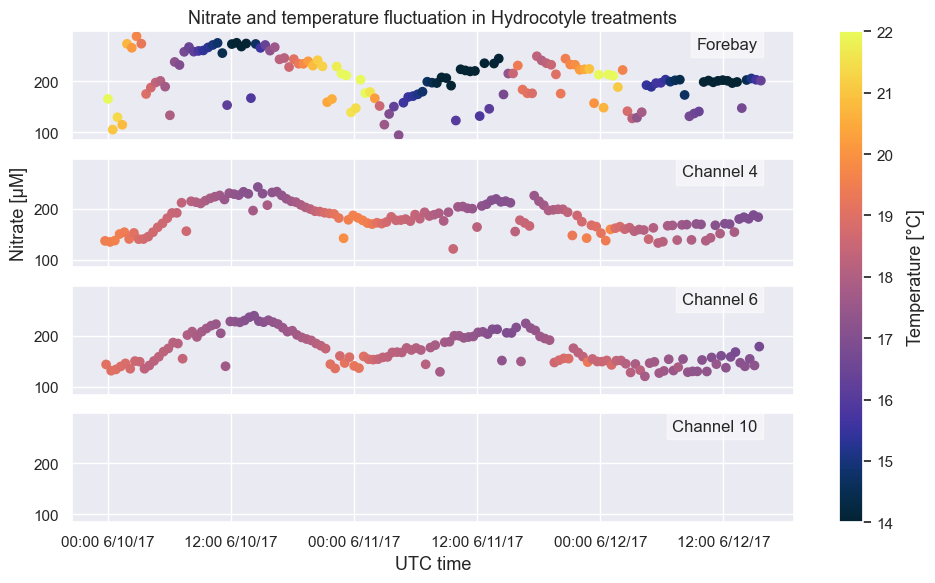

In [16]:
#Hydrocotyle channel temp plots
sns.set()
fig, axs = plt.subplots(4, sharex=True, sharey=True, figsize=[10,6])
scatter0 = axs[0].scatter(dffb_plot['utc_time'], dffb_plot['nitrate'], c=dffb_plot['temp'], cmap=cmo.thermal, vmin=14.0, vmax=22.0)
axs[0].set_title('Nitrate and temperature fluctuation in Hydrocotyle treatments', fontsize=13)

scatter1 = axs[1].scatter(dfc4_hPlot['utc_time'], dfc4_hPlot['nitrate'], c=dfc4_hPlot['temp'], cmap=cmo.thermal,vmin=14.0, vmax=22.0)
axs[1].set_ylabel('Nitrate [μM]', fontsize=13)

scatter2 = axs[2].scatter(dfc6_hPlot['utc_time'], dfc6_hPlot['nitrate'], c=dfc6_hPlot['temp'], cmap=cmo.thermal,vmin=14.0, vmax=22.0)

scatter3 = axs[3].scatter(dfc10_hPlot['utc_time'], dfc10_hPlot['nitrate'], c=dfc10_hPlot['temp'], cmap=cmo.thermal,vmin=14.0, vmax=22.0)
axs[3].set_xlabel('UTC time', fontsize=13)

axs[0].text(0.95, 0.95, 'Forebay', transform=axs[0].transAxes, fontsize=12, va='top', ha='right', bbox=dict(facecolor='white', alpha=0.5))
plt.tight_layout()
axs[1].text(0.95, 0.95, 'Channel 4', transform=axs[1].transAxes, fontsize=12, va='top', ha='right', bbox=dict(facecolor='white', alpha=0.5))
plt.tight_layout()
axs[2].text(0.95, 0.95, 'Channel 6', transform=axs[2].transAxes, fontsize=12, va='top', ha='right', bbox=dict(facecolor='white', alpha=0.5))
plt.tight_layout()
axs[3].text(0.95, 0.95, 'Channel 10', transform=axs[3].transAxes, fontsize=12, va='top', ha='right', bbox=dict(facecolor='white', alpha=0.5))
plt.tight_layout()

plt.gca().set_xticklabels(['00:00 6/10/17', '12:00 6/10/17', '00:00 6/11/17' , '12:00 6/11/17', '00:00 6/12/17', '12:00 6/12/17'])

cbar = fig.colorbar(scatter2, ax=axs.ravel().tolist(), orientation='vertical', pad=0.05)  # Adjust pad value for more spacing
cbar.set_label('Temperature [°C]', fontsize=13, labelpad=10)

## References